In [2]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import classifiers
from weighted_model import (
    FairTeacherStudentClassifier,
    TeacherStudentClassifier
)

# Import curriculum models
from curriculum_models import (
    CurriculumStudentTeacher,
    WeightedCurriculumStudentTeacher
)

# Import helpers
from helpers import (
    CurriculumHelper,
    FairnessEvaluatorHelper
)
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
np.random.seed(41) # Set seed for reproducibility
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = fetch_adult(as_frame=True)
df = data.frame
print(len(df))
df.head()


48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


race                class
Amer-Indian-Eskimo  <=50K    0.882979
                    >50K     0.117021
Asian-Pac-Islander  <=50K    0.730744
                    >50K     0.269256
Black               <=50K    0.879189
                    >50K     0.120811
Other               <=50K    0.876847
                    >50K     0.123153
White               <=50K    0.746013
                    >50K     0.253987
Name: proportion, dtype: float64


C:\Users\trdin\AppData\Local\Temp\ipykernel_19320\2974537177.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('race')['class'].value_counts(normalize=True))


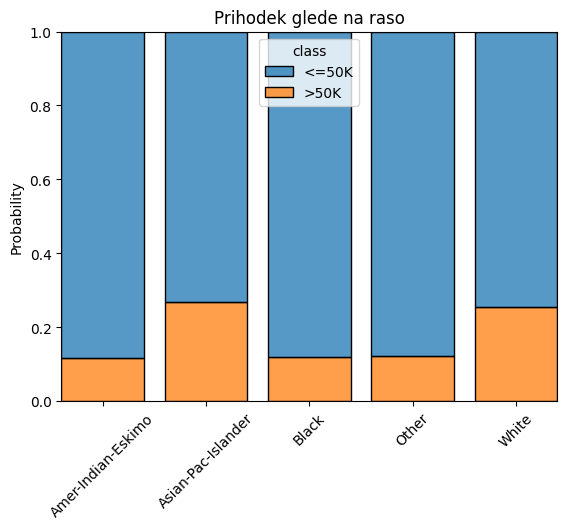

In [4]:
import matplotlib.pyplot as plt
print(df.groupby('race')['class'].value_counts(normalize=True))

sns.histplot(data=df, x='race', hue='class', stat='probability', multiple='fill', shrink=.8)
plt.title("Prihodek glede na raso")
plt.xticks(rotation=45)
plt.xlabel(None)
plt.show()

In [5]:
# Load dataset
data = fetch_adult(as_frame=True)
df = data.frame

# Preprocessing: Encode categorical variables
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Features and labels
X = df.drop(columns=['class'])
y = (df['class'] == '>50K').astype(int)  # Binary target: 1 if >50K, else 0
z = df['race']  # Sensitive attribute

# Stratified K-Fold Split
# Stratified K-Fold is used instead of regular K-Fold to ensure that each fold maintains 
# the same distribution of the sensetive variable (z). This is crucial when dealing with imbalanced datasets,
# as it prevents some folds from having disproportionately higher or lower occurrences of the target classes.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y, z)): # TODO 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    z_train, z_test = z.iloc[train_idx], z.iloc[test_idx]
    folds.append((X_train, X_test, y_train, y_test, z_train, z_test))

In [6]:
# Experiment 
# 

# Dictionary to store predictions
predictions = {"fairness_curriculum_SGD": [], "fairness_curriculum_SGD_asc": [],
               "weighted_curriculum_mode_0": [], "weighted_curriculum_mode_1": [], "weighted_curriculum_mode_2": [],
               "fair_classifier_split_mode_1": [], "diff_asc_model": [], "curriculum_model": [],
               "difficulty_based_model": [], "SGD_model": [], "student_teacher": [], "rf_classifier": []}


sensitive_feature = "race"

for fold_idx, (X_train, X_test, y_train, y_test, z_train, z_test) in enumerate(folds):

    # Initialize models
    # CurriculumStudentTeacher SGD with different trasnform functions
    fairness_curriculum_SGD = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"),transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
    fairness_curriculum_SGD_asc = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature, ascending=True))

    # WeightedCurriculumStudentTeacher with different modes for sample weights calculation
    weighted_curriculum_model_mode_0 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
    weighted_curriculum_model_mode_1 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))
    weighted_curriculum_model_mode_2 = WeightedCurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func=lambda X, y_prob, n_splits: CurriculumHelper.split_by_sensitive_feature_and_confidence(X, y_prob, sensitive_feature=sensitive_feature))

    # FairTeacherStudentClassifier the most succesfull clasifier from the previous experiments with weights
    fair_classifier_split_mode_1 = FairTeacherStudentClassifier(teacher=RandomForestClassifier(), student=SGDClassifier(average=True, loss="log_loss"), split_data=False)

    # Multiple curriculum models for reference
    curriculum_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_parts, n_splits=6)	

    difficulty_based_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_difficulty_parts, n_splits=6)

    diff_asc_model = CurriculumStudentTeacher(teacher=RandomForestClassifier(), student = SGDClassifier(average=True, loss="log_loss"), transform_func= CurriculumHelper.split_into_difficulty_parts_asc, n_splits=6)

    #Student Teacher models for reference
    student_teacher = TeacherStudentClassifier(teacher=RandomForestClassifier(), student=SGDClassifier(average=True, loss="log_loss"))

    #randomForrest for reference
    rf_classifier = RandomForestClassifier()

    #SGD for reference
    sgd_model = SGDClassifier(average=True, loss="log_loss")


    print(f"Training on fold {fold_idx + 1}...")
    
    # Train classifiers
    diff_asc_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    fairness_curriculum_SGD.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    fairness_curriculum_SGD_asc.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    weighted_curriculum_model_mode_0.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=0)
    weighted_curriculum_model_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)
    weighted_curriculum_model_mode_2.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=2)
    fair_classifier_split_mode_1.fit(X_train.copy(deep=False), y_train.copy(deep=False), z_train.copy(deep=False), mode=1)
    sgd_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    difficulty_based_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    curriculum_model.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    student_teacher.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    rf_classifier.fit(X_train.copy(deep=False), y_train.copy(deep=False))
    
    print(f"Predicting on fold {fold_idx + 1}...")
    predictions["fairness_curriculum_SGD"].append(fairness_curriculum_SGD.predict(X_test))
    predictions["fairness_curriculum_SGD_asc"].append(fairness_curriculum_SGD_asc.predict(X_test))
    predictions["weighted_curriculum_mode_0"].append(weighted_curriculum_model_mode_0.predict(X_test))
    predictions["weighted_curriculum_mode_1"].append(weighted_curriculum_model_mode_1.predict(X_test))
    predictions["weighted_curriculum_mode_2"].append(weighted_curriculum_model_mode_2.predict(X_test))
    predictions["fair_classifier_split_mode_1"].append(fair_classifier_split_mode_1.predict(X_test))
    predictions["diff_asc_model"].append(diff_asc_model.predict(X_test))
    predictions["curriculum_model"].append(curriculum_model.predict(X_test))
    predictions["difficulty_based_model"].append(difficulty_based_model.predict(X_test))
    predictions["SGD_model"].append(sgd_model.predict(X_test))
    predictions["student_teacher"].append(student_teacher.predict(X_test))
    predictions["rf_classifier"].append(rf_classifier.predict(X_test))
    
    print(f"Fold {fold_idx + 1} complete.\n")


Training on fold 1...
Min accuracy group: 4
Min accuracy group: 4
Predicting on fold 1...
Fold 1 complete.

Training on fold 2...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 2...
Fold 2 complete.

Training on fold 3...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 3...
Fold 3 complete.

Training on fold 4...
Min accuracy group: 2
Min accuracy group: 2
Predicting on fold 4...
Fold 4 complete.

Training on fold 5...
Min accuracy group: 4
Min accuracy group: 4
Predicting on fold 5...
Fold 5 complete.



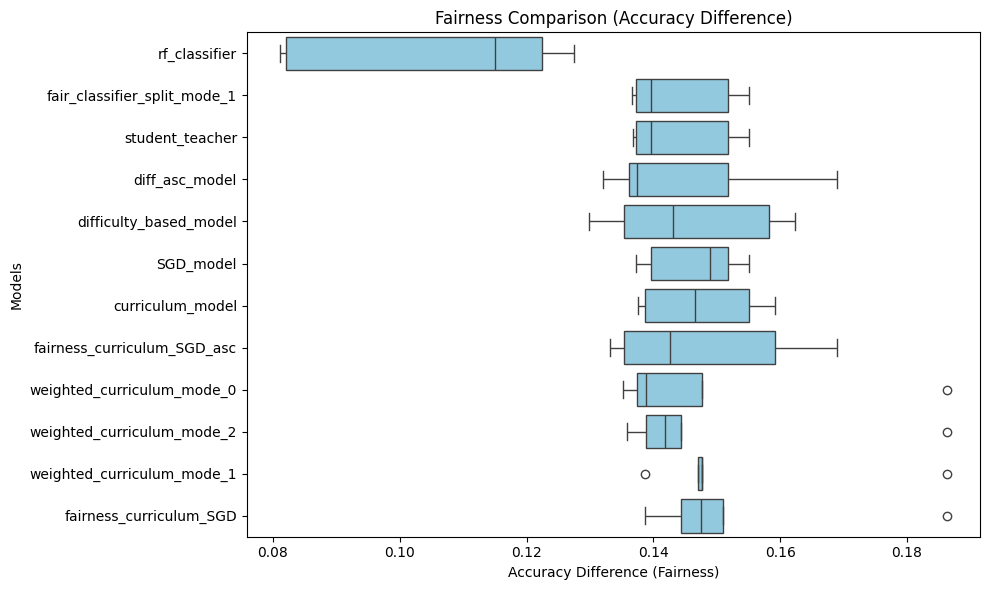

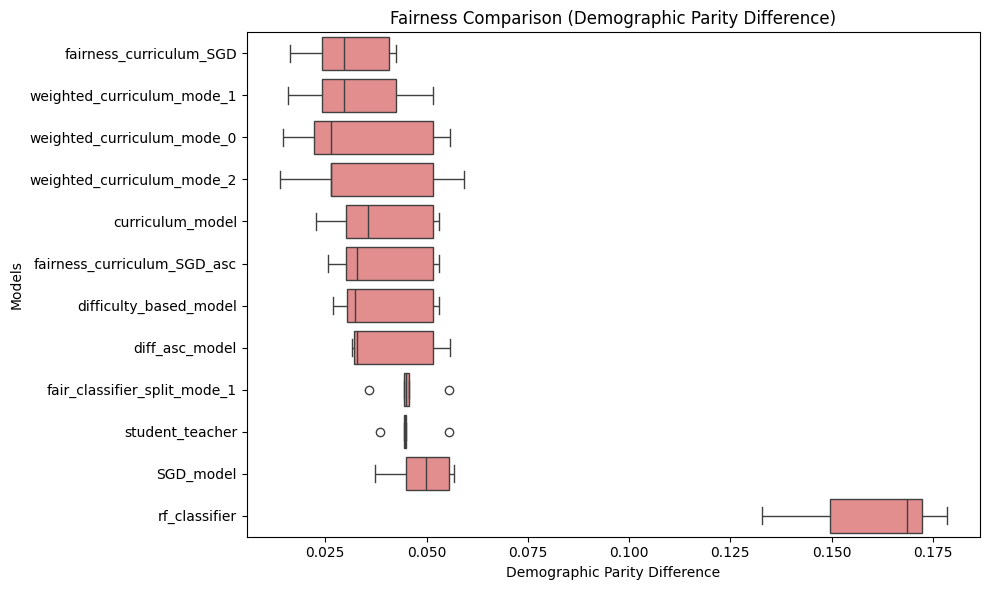

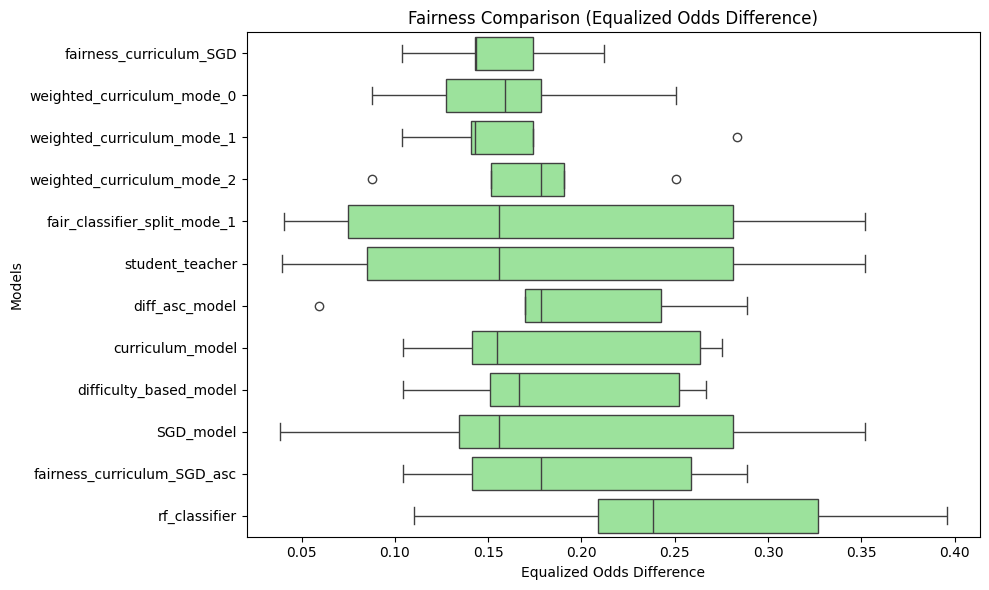

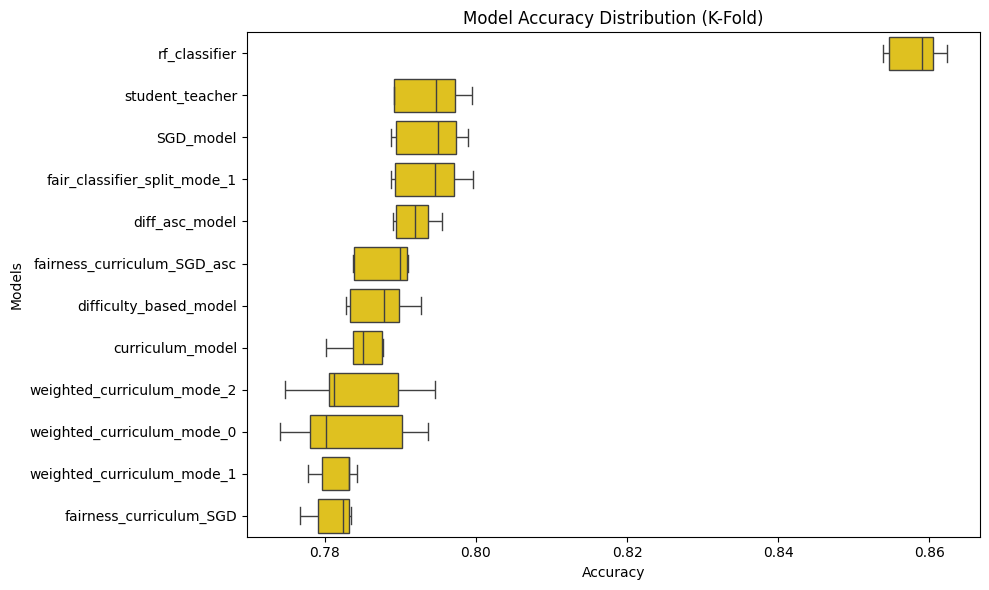

In [7]:
# Instantiate the fairness evaluator
evaluator = FairnessEvaluatorHelper(folds, predictions)

# Compute all fairness metrics
evaluator.compute_fairness_metrics()

# Plot sorted fairness metrics
evaluator.plot_accuracy_differences()
evaluator.plot_demographic_parity()
evaluator.plot_equalized_odds()
evaluator.plot_accuracies()


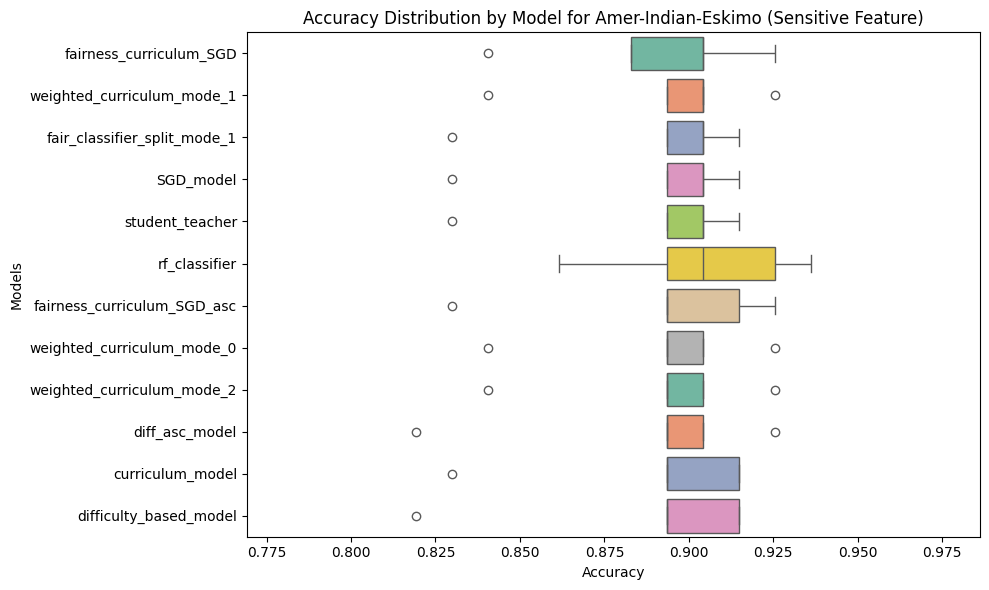

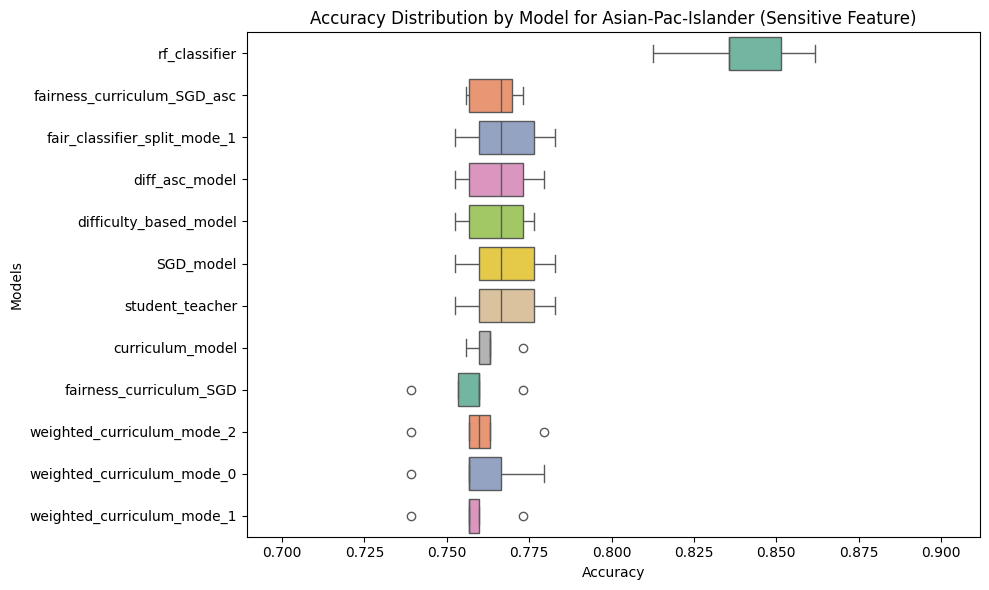

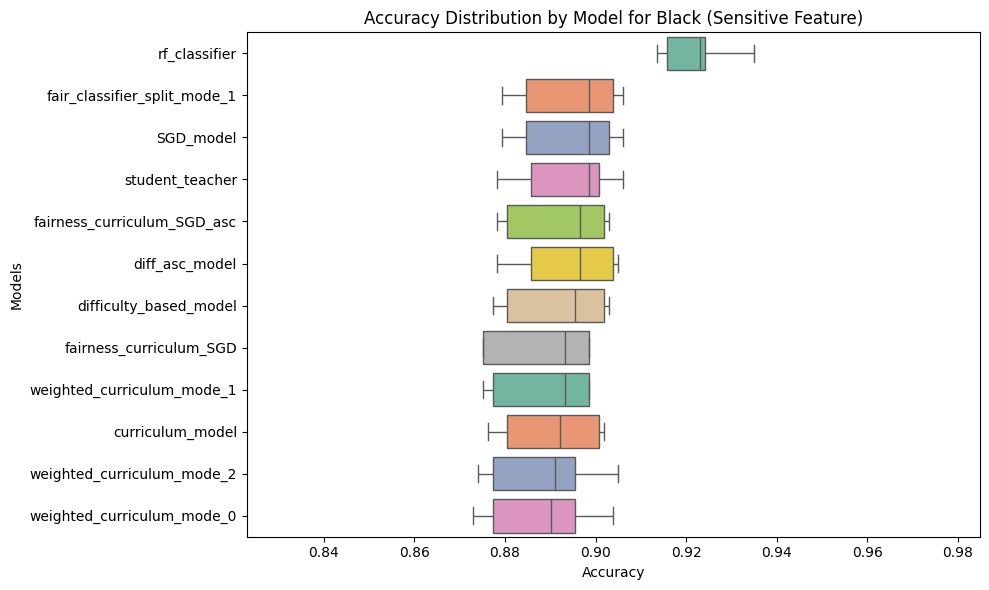

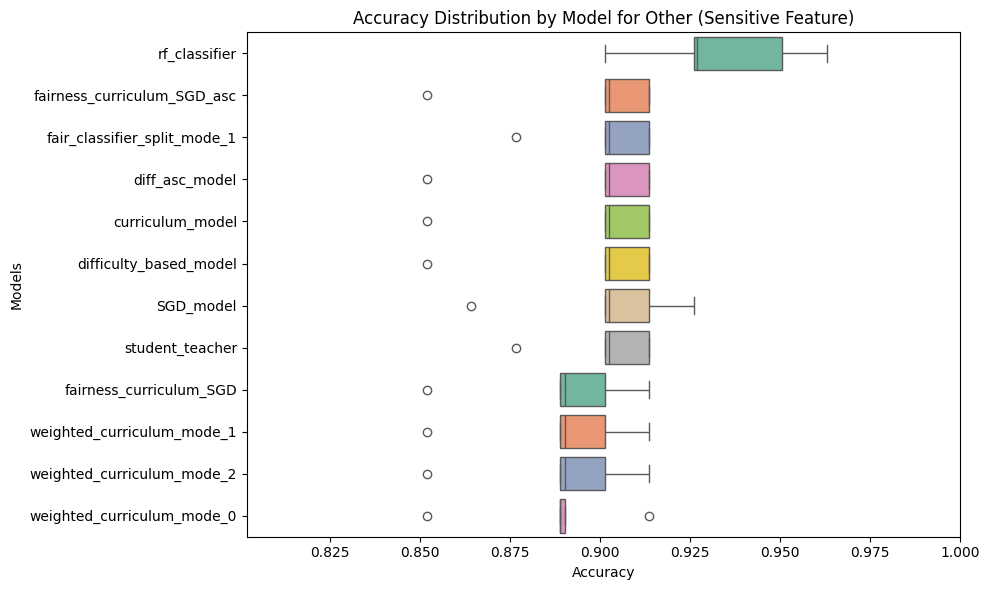

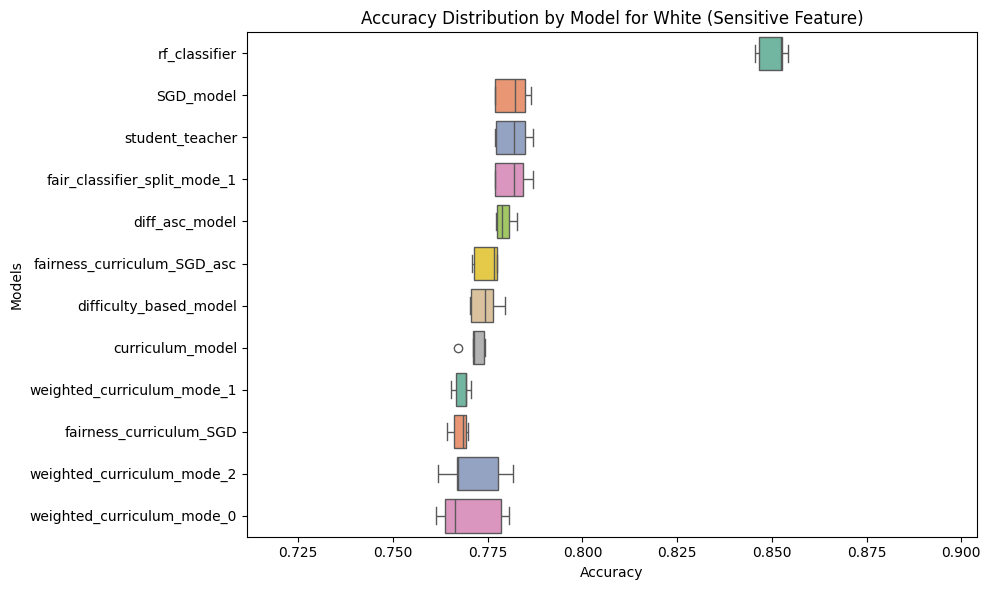

In [8]:
# Plot per-group accuracy distributions
evaluator.plot_group_accuracies(label_encoder=label_encoders['race'])

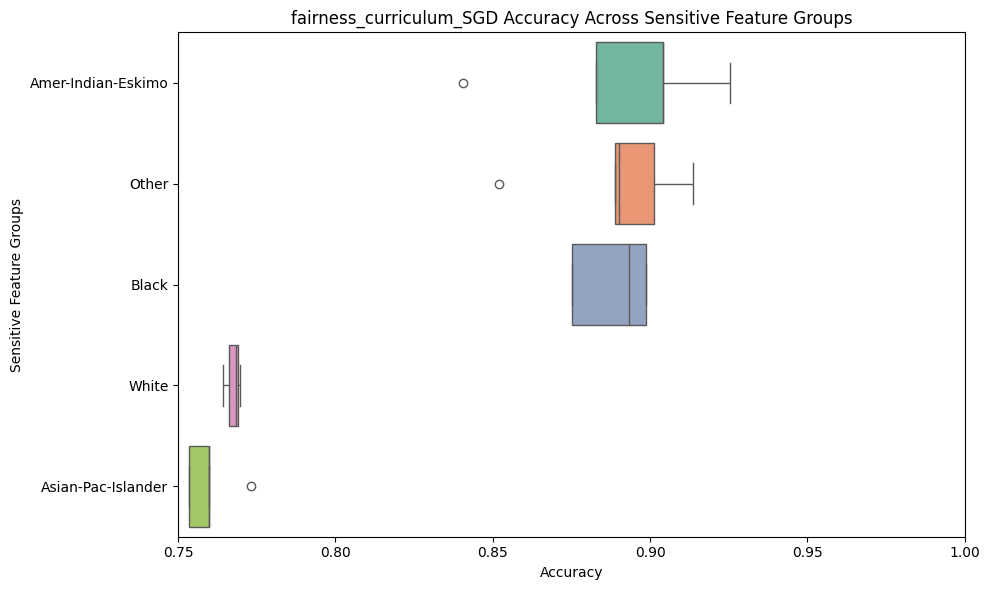

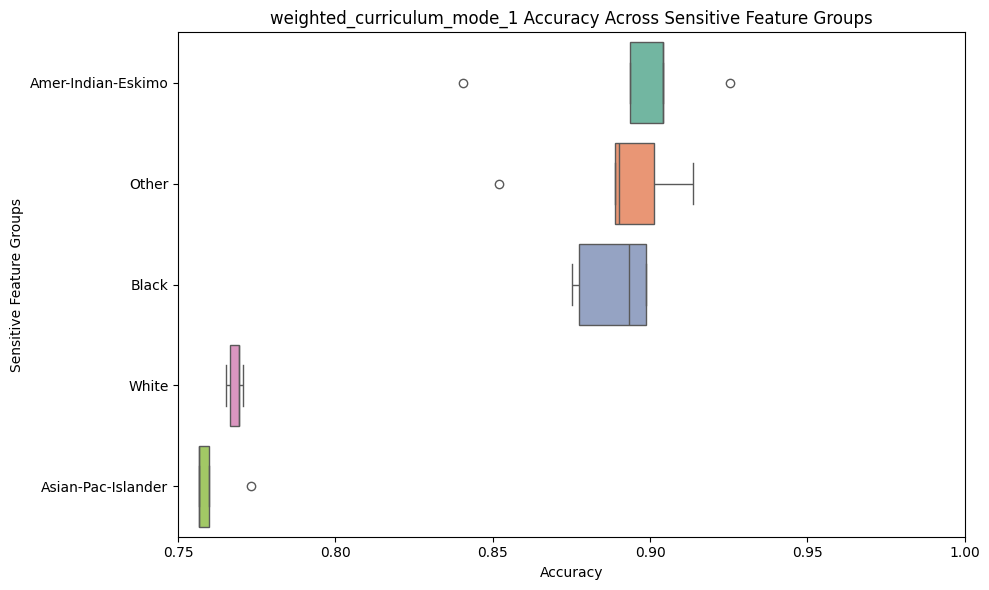

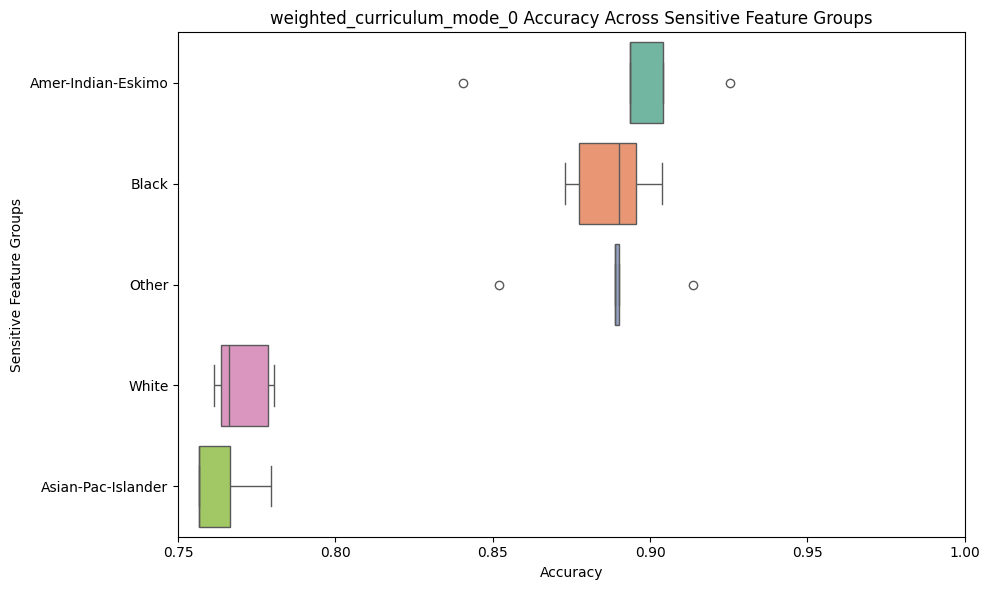

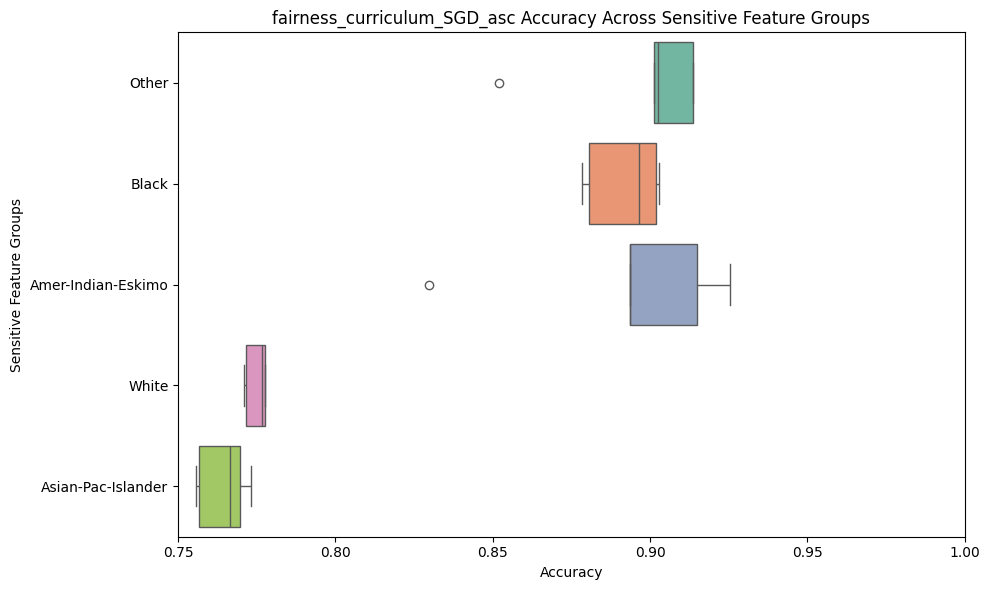

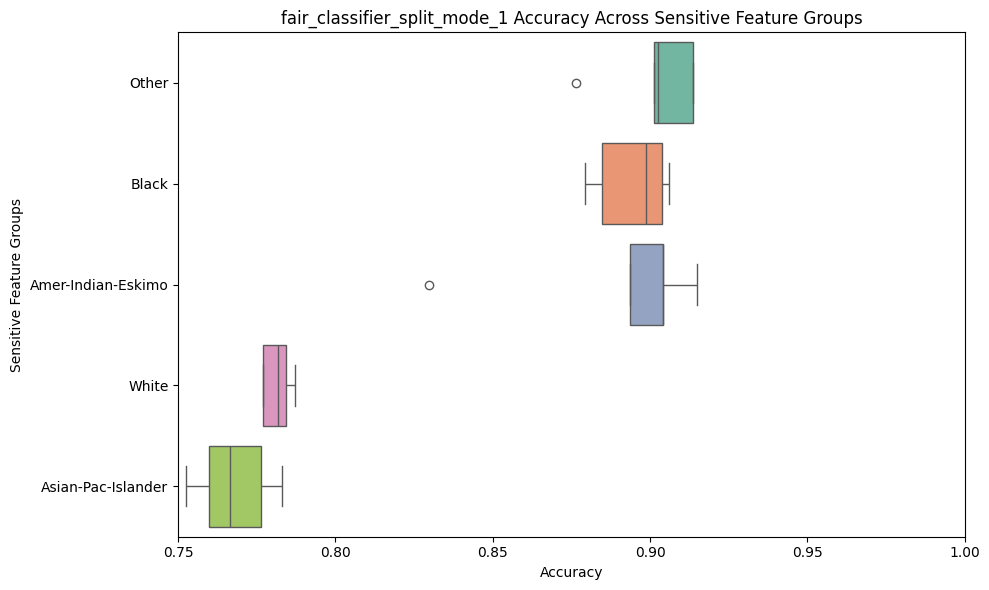

In [9]:
selected_models = [
    "fairness_curriculum_SGD",      # Fair Curriculum Model SGD
    "weighted_curriculum_mode_0",   # Weighted Curriculum Mode 0
    "weighted_curriculum_mode_1",   # Weighted Curriculum Mode 1
    "fair_classifier_split_mode_1", # Fair Classifier Split Mode 1
    "fairness_curriculum_SGD_asc"   # Fair Curriculum Model SGD Asc
]

evaluator.plot_selected_model_accuracies_by_sensetive_feature(selected_models= selected_models, label_encoder=label_encoders['race'])